In [15]:
!pip install datasets

import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re




In [5]:
dataset = load_dataset("artem9k/ai-text-detection-pile")
print(dataset)


README.md: 0.00B [00:00, ?B/s]

c:\Users\Magsihim_AI\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Magsihim_AI\.cache\huggingface\hub\datasets--artem9k--ai-text-detection-pile. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to re

(…)-00000-of-00007-bc5952582e004d67.parquet:   0%|          | 0.00/758M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00001-of-00007-71c80017bc45f30d.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00002-of-00007-ee2d43f396e78fbc.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00003-of-00007-529931154b42b51d.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00004-of-00007-b269dc49374a2c0b.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00005-of-00007-3dce5e05ddbad789.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00006-of-00007-3d8a471ba0cf1c8d.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1392522 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})


In [7]:
df = dataset["train"].to_pandas()
df.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [9]:
print(df.isnull().sum())


source    0
id        0
text      0
dtype: int64


source
human    1028146
ai        364376
Name: count, dtype: int64


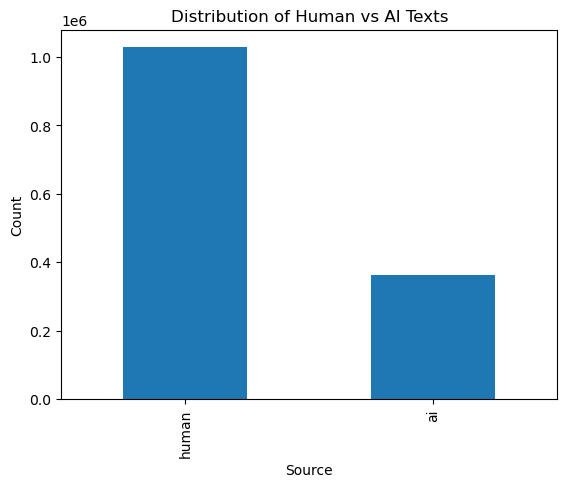

In [11]:
print(df["source"].value_counts())
df["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.show()

In [12]:
df["text_length"] = df["text"].str.len()

print(df.groupby("source")["text_length"].mean())

source
ai       2221.160949
human    2466.855142
Name: text_length, dtype: float64


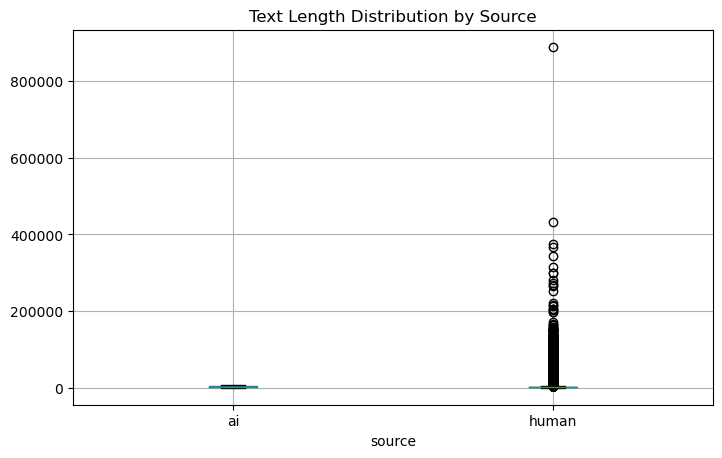

In [14]:
df.boxplot(column="text_length", by="source", figsize=(8,5))
plt.title("Text Length Distribution by Source")
plt.suptitle("")
plt.show()

In [16]:
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df["sentence_count"] = df["text"].apply(count_sentences)

In [17]:
print(df.groupby("source")["sentence_count"].mean())       # average sentences
print(df.groupby("source")["sentence_count"].describe())   # stats


source
ai       17.907859
human    24.961971
Name: sentence_count, dtype: float64
            count       mean        std  min   25%   50%   75%     max
source                                                                
ai       364376.0  17.907859  14.606204  0.0   6.0  14.0  28.0   421.0
human   1028146.0  24.961971  36.695571  0.0  11.0  15.0  25.0  3342.0


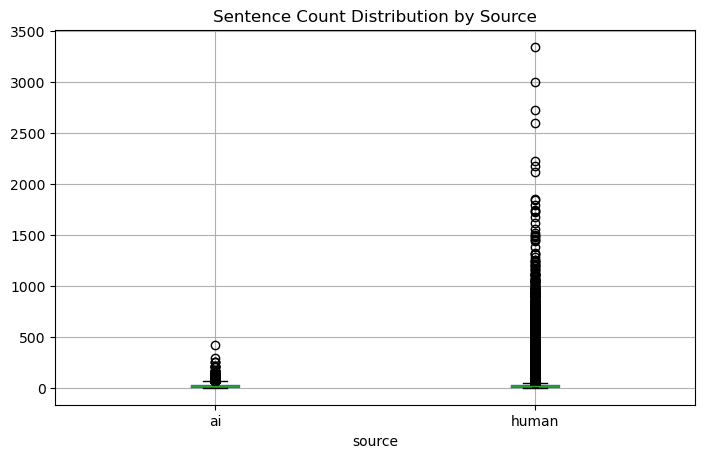

In [20]:
df.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

In [21]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split into sentences
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    sentences = [s for s in sentences if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    return sum(word_counts) / len(word_counts)

df["word_count"] = df["text"].apply(count_words)
df["avg_words_per_sentence"] = df["text"].apply(avg_words_per_sentence)


        word_count  avg_words_per_sentence
source                                    
ai      387.003307               23.392306
human   406.335384               17.559382
       word_count                                                             \
            count        mean         std  min    25%    50%    75%      max   
source                                                                         
ai       364376.0  387.003307  296.514355  0.0  111.0  305.0  693.0   1024.0   
human   1028146.0  406.335384  635.398902  0.0  174.0  190.0  394.0  71543.0   

       avg_words_per_sentence                                        \
                        count       mean        std  min        25%   
source                                                                
ai                   364376.0  23.392306  18.495902  0.0  17.377778   
human               1028146.0  17.559382  14.849826  0.0  12.062500   

                                      
              50%        75%    

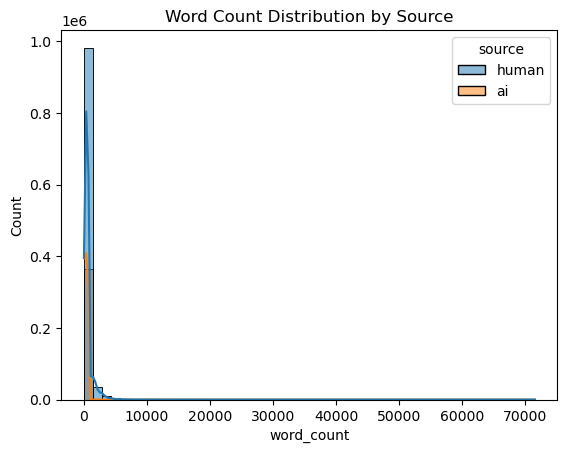

In [22]:
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].mean())
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].describe())
sns.histplot(data=df, x="word_count", hue="source", kde=True, bins=50)
plt.title("Word Count Distribution by Source")
plt.show()

In [23]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence
0,human,0,12 Years a Slave: An Analysis of the Film Essa...,4315,41,692,16.878049
1,human,1,20+ Social Media Post Ideas to Radically Simpl...,2400,26,367,14.115385
2,human,2,2022 Russian Invasion of Ukraine in Global Med...,1870,12,302,25.166667
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...,2413,35,384,10.971429
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...,2339,25,352,13.960000
